### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

### Add activation functions

In [2]:
def sigmoid(x, derivative=False):
    if derivative:
        return np.exp(x) / ((1 + np.exp(x)) ** 2)
    return 1/(1+np.exp(-x))

def linear(x, derivative=False):
    if derivative:
        return np.ones(x.shape)
    return x

def softmax(x, derivative=False):
    if derivative:
        return - np.e**x / (np.sum(np.e**x, axis=0) ** 2)
    return np.e**x / np.sum(np.e**x, axis=0)

### Initialize weights

In [3]:
def init_weights(neurons_in, neurons_out, init_method='Xavier'):
    if init_method == 'zeros':
        weights = np.zeros([neurons_out, neurons_in])
        bias = np.zeros([neurons_out,1])
    elif init_method == 'uniform':
        weights = np.random.uniform(0,1, (neurons_out, neurons_in))
        bias = np.random.uniform(0,1,(neurons_out,1))
    elif init_method == 'Xavier':
        weights = np.random.randn(neurons_out, neurons_in)*np.sqrt(1/(neurons_in))
        bias = np.random.randn(neurons_out,1)*np.sqrt(1/(neurons_in))
    elif init_method == "He":
        weights = np.random.randn(neurons_out, neurons_in)*np.sqrt(2/(neurons_in+neurons_out)) 
        bias = np.random.randn(neurons_out,1)*np.sqrt(2/(neurons_in+neurons_out))
    return weights, bias

### Prepare data

In [4]:
def readcsv(path):
    return np.genfromtxt(path, delimiter=',')[1:, 1:]

def split_data(data):
    x = data[:, 0:1] # inputs
    y = data[:, 1:2] # outputs
    return x,y

def shuffle_batch(x, y):
    t = np.arange(x.shape[0])
    np.random.shuffle(t)
    return x[t], y[t]

def scale(X):
    return (X-np.mean(X, 0))/np.std(X, 0)

def one_hot_encoding(y):
    y = pd.DataFrame(y)
    y = pd.get_dummies(y[0])
    return np.array(y)

### Define measures

In [5]:
def MSE(x, y):
    return np.mean((x - y) ** 2)

def accuracy(y_pred, y):
    return np.sum(y.T == y_pred)/y.shape[0]

### Layer class

In [7]:
class Layer:
    def __init__(self, neurons_in, neurons_out, activ_function, init_method):
        
        self.neurons_in = neurons_in
        self.neurons_out = neurons_out
        self.activ_function = activ_function
        self.weights, self.bias = init_weights(neurons_in, neurons_out, init_method)

        self.momentum_weights = np.zeros([neurons_out, neurons_in])
        self.momentum_bias = np.zeros([neurons_out,1])
        self.grad_squared_weights = np.zeros([neurons_out, neurons_in])
        self.grad_squared_bias = np.zeros([neurons_out,1])

    def forward(self, x):
        self.forward_linear = self.weights @ x + self.bias
        return self.activ_function(self.forward_linear)

    def backpropagate_last_layer(self, y, y_pred):
        self.forward_gradient = self.activ_function(self.forward_linear, derivative=True)        
        
        if not self.activ_function==softmax:
            self.backward_error = (y_pred.T - y.T) * self.forward_gradient
        else:
            ex = np.exp(self.forward_linear)
            sum_ex = np.sum(ex, axis=0)
            gradient = sum_ex * ex / (sum_ex) ** 2
            self.backward_error = (y_pred.T-y.T) * gradient
            for i in range(self.forward_linear.shape[0]):
                self.backward_error[i, :] += np.sum((y_pred.T-y.T) * self.forward_gradient, axis=0) * ex[i, :]

    def backpropagate_layer(self, error_weight):
        self.forward_gradient = self.activ_function(self.forward_linear, derivative=True)
        self.backward_error = error_weight.T * self.forward_gradient
        
    def error_weight(self):
        return self.backward_error.T @ self.weights

    def update_weights(self, previous_result, alpha, beta, gradient_method):
        d_weights = self.backward_error @ previous_result.T
        d_bias = np.sum(self.backward_error)

        if gradient_method == 'gradient_descent':
            self.weights -= alpha * d_weights
            self.bias -= alpha * d_bias
            
        elif gradient_method == 'momentum':
            self.momentum_weights = beta * self.momentum_weights + d_weights  
            self.momentum_bias = beta * self.momentum_bias + d_bias  
            
            self.weights -= alpha * self.momentum_weights
            self.bias -= alpha * self.momentum_bias
            
        elif gradient_method == 'RMSProp':
            self.grad_squared_weights =  beta * self.grad_squared_weights  + (1-beta) * np.square(d_weights) 
            self.grad_squared_bias = beta * self.grad_squared_bias  + (1-beta) * np.square(d_bias) 
            
            self.weights -=  alpha * d_weights / (np.sqrt(self.grad_squared_weights))
            self.bias -= alpha * d_bias / (np.sqrt(self.grad_squared_bias))


### Neural Network class

In [8]:
class NeuralNetwork:
    def __init__(self, neurons, activ_function, last_activ=softmax, init_method='Xavier'):
        
        self.layers = []
        for i in range(len(neurons)-2):
            self.layers.append(Layer(neurons[i], neurons[i+1], activ_function, init_method))
        self.layers.append(Layer(neurons[i+1], neurons[i+2], last_activ, init_method))

        self.predictions = []

    def forward(self, x):
        self.predictions = []
        x = x.T
        for i in range(len(self.layers)):
            x = self.layers[i].forward(x)
            self.predictions.append(x)
        return x.T

    def backward(self, x, y, alpha=0.001, batch_size=50, n_epochs=1, beta=0.5, gradient_method='gradient_descent'):
        n_batches = math.ceil(x.shape[0]/batch_size)
        for j in range(n_epochs):
            x, y = shuffle_batch(x, y)
            for i in range(n_batches):
                self.backward_batch(x[i*batch_size:(i+1)*batch_size, :], y[i*batch_size:(i+1)*batch_size, :], alpha, beta, gradient_method)

    def backward_batch(self, x, y, alpha,  beta, gradient_method):
        y_pred = self.forward(x)
        self.layers[-1].backpropagate_last_layer(y, y_pred)
        for i in range(len(self.layers)-2, -1, -1):
            error_weight = self.layers[i+1].error_weight()
            self.layers[i].backpropagate_layer(error_weight)
        self.update_weights(x, alpha, beta, gradient_method)
        
    def update_weights(self, x, alpha,  beta, gradient_method):
        self.layers[0].update_weights(x.T, alpha, beta, gradient_method)
        for i in range(1, len(self.layers)):
            self.layers[i].update_weights(self.predictions[i - 1], alpha, beta, gradient_method)

### Training network

In [39]:
def train_network(x, y, neurons, activ_function, last_activ, init_method='Xavier', gradient_method='RMSProp', beta=0.9, alpha=0.01, n_epochs=1, batch_size=50, n_iter=20, regression=True, print_measures=True):

    y_before_encoding = y
    if not regression:
        y = one_hot_encoding(y)        
   
    network = NeuralNetwork(neurons, activ_function, last_activ, init_method=init_method)

    errors = []
    y_pred = network.forward(x)
    
    if regression:
            errors.append(MSE(y_pred, y))
            measure = "MSE"
    else:
        y_pred = np.argmax(y_pred, axis=1)
        errors.append(accuracy(y_pred, y_before_encoding)) 
        measure = "accuracy"

    for i in range(n_iter):
        if gradient_method == 'gradient_descent':
            network.backward(x, y, alpha=alpha, n_epochs=n_epochs, batch_size= batch_size)
        if gradient_method == 'momentum':
            network.backward(x, y, alpha=alpha, n_epochs=n_epochs, batch_size= batch_size, beta=beta, gradient_method='momentum')
        if gradient_method == 'RMSProp':
            network.backward(x, y, alpha=alpha, n_epochs=n_epochs, batch_size= batch_size, beta=beta, gradient_method='RMSProp')

        y_pred = network.forward(x)
        
        if regression:
            errors.append(MSE(y_pred, y))
            measure = "MSE"
        else:
            y_pred = np.argmax(y_pred, axis=1)
            errors.append(accuracy(y_pred, y_before_encoding)) 
            measure = "accuracy"
        if print_measures:
            if i % 20==0:
                print(measure+': '+str(errors[-1]))
    
    return errors, network

# Testing with data

## Easy-data

### Load data

In [40]:
data = pd.read_csv('easy-training.csv')
data['c'][data['c']==False]=0
data['c'][data['c']==True]=1
data = np.array(data)
x = data[:,0:2]
y = data[:,2:3]

<ipython-input-40-35c4e6771b8f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['c'][data['c']==False]=0


## Visualize data

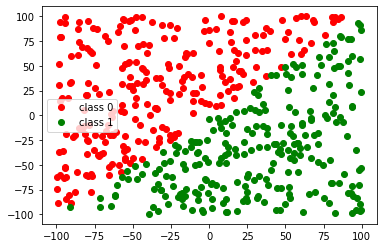

In [41]:
plt.figure()
uniques = np.unique(y[:, 0])
colors = ['r', 'g', 'b']
legend = []
for i in range(len(uniques)):
    ax = x[:, 0][y[:, 0] == uniques[i]]
    ay = x[:, 1][y[:, 0] == uniques[i]]
    plt.plot(ax, ay, colors[i] + 'o')
    legend.append('class ' + str(int(uniques[i])))
plt.legend(legend)
plt.show()

### Train network with two hidden layers 

In [42]:
print(x.shape)
print(len(np.unique(y)))

(500, 2)
2


In [43]:
errors, network = train_network(x, y,[2,30,30,2], sigmoid, softmax, beta=0.01, alpha=0.01, n_epochs=1, n_iter=100, regression=False, gradient_method="momentum", init_method='Xavier')

accuracy: 0.926
accuracy: 0.994
accuracy: 0.998
accuracy: 0.998
accuracy: 0.998


### Visualize results


In [44]:
y_pred = np.argmax(network.forward(x), axis=1)

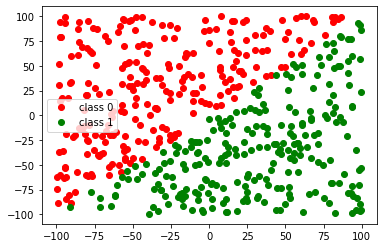

In [45]:
plt.figure()
uniques = np.unique(y_pred)
colors = ['r', 'g']
legend = []
for i in range(len(uniques)):
    ax = x[:, 0][y_pred == uniques[i]]
    ay = x[:, 1][y_pred == uniques[i]]
    plt.plot(ax, ay, colors[i] + 'o')
    legend.append('class ' + str(int(uniques[i])))
plt.legend(legend)
plt.show()

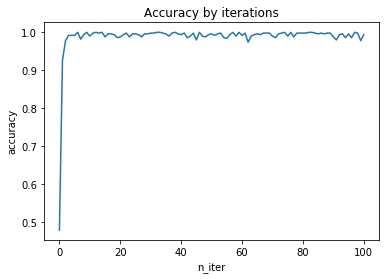

In [46]:
plt.figure()
plt.plot(errors)
plt.title('Accuracy by iterations')
plt.xlabel('n_iter')
plt.ylabel('accuracy')
plt.show()

Szybka zbieżność

### Compare with linear activation function on last layer

In [49]:
errors2, network = train_network(x, y, [2,30,30,2], sigmoid, linear, beta=0.01, alpha=0.01, n_epochs=1, n_iter=100, regression=False, gradient_method="momentum", print_measures=False)

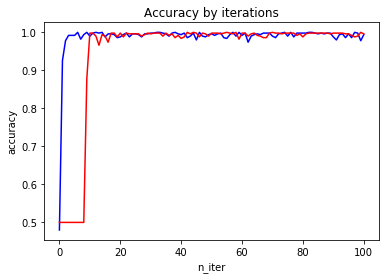

In [50]:
plt.figure()
plt.plot(errors, 'b')
plt.plot(errors2, 'r')
plt.title('Accuracy by iterations')
plt.xlabel('n_iter')
plt.ylabel('accuracy')
plt.show()

Softmax zbiega szybciej.

## Xor3-training

### Load data

In [51]:
data = np.genfromtxt('xor3-training.csv', delimiter=',')[1:,]
x = data[:, 0:2]
y = data[:, 2:3]

## Visualize data

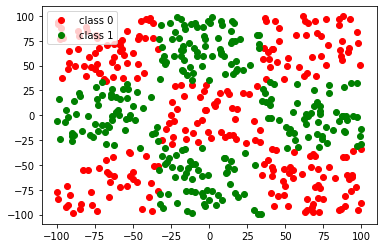

In [52]:
plt.figure()
uniques = np.unique(y[:, 0])
colors = ['r', 'g']
legend =  []
for i in range(len(uniques)): 
    ax = x[:, 0][y[:, 0] == uniques[i]]
    ay = x[:, 1][y[:, 0] == uniques[i]]
    plt.plot(ax, ay, colors[i] + 'o')
    legend.append('class ' + str(int(uniques[i])))
plt.legend(legend)
plt.show()

### Train network with two hidden layers 

In [53]:
errors, network = train_network(x, y, [2,30,30,2], sigmoid, softmax, beta=0.01, alpha=0.01, n_epochs=1, n_iter=200, regression=False, gradient_method="momentum")

accuracy: 0.5
accuracy: 0.5
accuracy: 0.85
accuracy: 0.86
accuracy: 0.878
accuracy: 0.884
accuracy: 0.872
accuracy: 0.85
accuracy: 0.876
accuracy: 0.882


### Visualize results


In [54]:
y_pred = np.argmax(network.forward(x), axis=1)

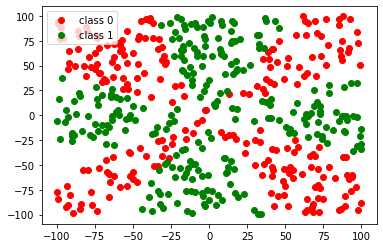

In [55]:
plt.figure()
uniques = np.unique(y_pred)
colors = ['r', 'g']
legend = []
for i in range(len(uniques)):
    ax = x[:, 0][y_pred == uniques[i]]
    ay = x[:, 1][y_pred == uniques[i]]
    plt.plot(ax, ay, colors[i] + 'o')
    legend.append('class ' + str(int(uniques[i])))
plt.legend(legend)
plt.show()

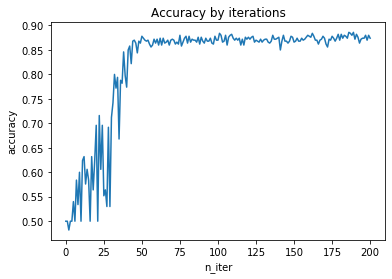

In [56]:
plt.figure()
plt.plot(errors)
plt.title('Accuracy by iterations')
plt.xlabel('n_iter')
plt.ylabel('accuracy')
plt.show()

## Rings3-regular-training


### Load data

In [57]:
data = np.genfromtxt('rings3-regular-training.csv', delimiter=',')[1:,]
x = data[:, 0:2]
y = data[:, 2:3]

## Visualize data

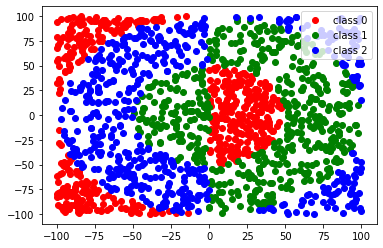

In [58]:
plt.figure()
uniques = np.unique(y[:, 0])
colors = ['r', 'g', 'b']
legend = []
for i in range(len(uniques)): #index, unique in enumerate(uniques):
    ax = x[:, 0][y[:, 0] == uniques[i]]
    ay = x[:, 1][y[:, 0] == uniques[i]]
    plt.plot(ax, ay, colors[i] + 'o')
    legend.append('class ' + str(int(uniques[i])))
plt.legend(legend)
plt.show()

### Train network with two hidden layers 

In [59]:
errors, network = train_network(x, y, [2,30,30,3], sigmoid, softmax, beta=0.01, alpha=0.01, n_epochs=1, n_iter=300, regression=False, gradient_method="gradient_descent")

accuracy: 0.4886666666666667
accuracy: 0.5186666666666667
accuracy: 0.546
accuracy: 0.5266666666666666
accuracy: 0.5693333333333334
accuracy: 0.5653333333333334
accuracy: 0.5746666666666667
accuracy: 0.682
accuracy: 0.7053333333333334
accuracy: 0.6473333333333333
accuracy: 0.734


<ipython-input-2-aa4dd129579c>:3: RuntimeWarning: overflow encountered in square
  return np.exp(x) / ((1 + np.exp(x)) ** 2)


accuracy: 0.7586666666666667
accuracy: 0.716
accuracy: 0.778
accuracy: 0.7906666666666666


### Visualize results


In [60]:
y_pred = np.argmax(network.forward(x), axis=1)

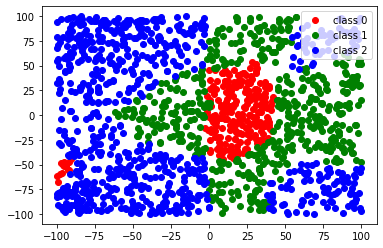

In [61]:
plt.figure()
uniques = np.unique(y_pred)
colors = ['r', 'g', 'b']
legend = []
for i in range(len(uniques)):
    ax = x[:, 0][y_pred == uniques[i]]
    ay = x[:, 1][y_pred == uniques[i]]
    plt.plot(ax, ay, colors[i] + 'o')
    legend.append('class ' + str(int(uniques[i])))
plt.legend(legend)
plt.show()

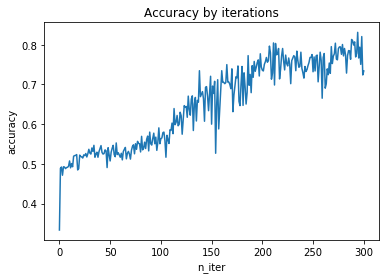

In [62]:
plt.figure()
plt.plot(errors)
plt.title('Accuracy by iterations')
plt.xlabel('n_iter')
plt.ylabel('accuracy')
plt.show()